# About this practical session
In this practical session, we will analyze U.S. mobility data from *Kang, Yuhao, et al. "Multiscale dynamic human mobility flow dataset in the US during the COVID-19 epidemic." Scientific Data 7.1 (2020): 390*.

**Goal**: Start with high-resolution human mobility data to extract and visualize the properties of the resulting mobility network

Outline:
- Data inspection, formatting, aggregation, and basic statistics
- Compute the degree distribution of the mobility network
- Create a choropleth map
- Analyze mobility changes during COVID-19 and compare long and short travels
- Fit a gravity model
- Graph representation of the mobility network 

## Data details 
The raw GPS pings were preprocessed to extract flows between locations through the following steps:

- Noise Removal
- Clustering GPS pings
- Home Location Estimation (Each user's home location is determined based on the most common nighttime location over a six-week period. This is done by clustering GPS pings that occur during nighttime hours (6 PM - 7 AM))
- POIs (Points of Interest) Estimation (Points of Interest (POIs) are tracked using clustering methods that associate each cluster of pings with a POI or a geographic location)
- Visits from home place to various POIs and CBGs are identified
- Population Flow Estimation: Since the mobile phone data only covers about 10% of the population, the study uses demographic data to infer population-level flows. This involves scaling the observed mobile phone data to represent the entire population.

We are going to use the daily Origin-Destination (OD) Matrix that contains the flow between each pair of Census Block Groups (CBG). In other words, this metric estimates the number of individuals who travel from an origin CBG to a destination CBG each day.

We will work with the daily Origin-Destination (OD) matrix, which estimates the number of individuals traveling each day from one Census Block Groups (CBG) to another.

&nbsp;<br><br><br><br>

---
# A primer of pandas DataFrame
A pandas DataFrame `df` is a two-dimensional, labeled data structure with rows and columns

|           | name    | age | city     |
| --------- | ------- | --- | -------- |
| **index** |         |     |          |
| 0         | Alice   | 25  | New York |
| 1         | Bob     | 30  | London   |
| 2         | Charlie | 22  | Paris    |


### Inspect
- `len(df)` — get the rows counts
- `df.head()` — show the first rows in the table 
### Select
- `df.columns` — get the list of columns (*ex. name, age, city*)
- `df.index` — get the list of index (*ex. 0,1,2,...)
- `df['col']` — select a single column by column name
- `df[['col1', 'col2']]` — select multiple columns  
- `df.loc[row_label]` — select row by index label  
- `df.iloc[row_number]` — select row by position  
### Apply Function to Column
- `df['col'].apply(lambda x: x * 2)` — apply a function to each value in a column  
- `df['col'].mean()` — average of a column — similarly `.min()`,  `max()` 
- `df['col'].sum()` — total  of a column
- `df['col'].describe()` — summary stats
### Assign  
- `df['new_col'] = df['col'] * 2` — create a new column based on existing data
- `df['new_col'] = 5` — create a new column with a constant value
### Group by  
The groupby() function splits the data into groups based on a column’s values, allowing you to apply aggregate functions like sum() or mean() to each group.
- `df.groupby(['col_name1', 'col_name2', ...])[['value_col', ...]].sum()` — total per group  
- `df.groupby(['col_name1', 'col_name2', ...])[['value_col', ...]].mean()` — average per group
- other aggregating functions: `.nunique()`, `.count()`
### Filter
- `df.loc[df['col'] == value]` — select rows where a column equals a value
- `df.loc[(df['col1'] > x) & (df['col2'] < y)]` — multiple conditions (use `&`, `|`)  
or use query:
- `df.query("col == value")` — use string-based expressions
- `df.query("col in [1,2]")` — select rows where values of column are in a set  
- `df.query("col1 > x and col2 < y")` — multiple conditions with readable synta
- `df.query("col1 == col2")` — columns comparison (get all the rows where the values of col1 is equal to col2)
- `df.query("col == @variable_name")` — use @ to reference local Python variables in the expression

---
&nbsp;<br><br><br><br><br><br><br><br><br>

# Import libraries

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

import os
import geopandas as gpd
import statsmodels.api as sm

In [3]:
# If you encounter an ImportError, install the packages using the following command:
# !pip install geopandas

In [4]:
# Function to format dates on plots
def dateFormat(ax):
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator, show_offset=False)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

# Inspect a sample of the data

In [11]:
# Load a sample of daily CBG-to-CBG visitor flows
# If executing on Google Colab, change the path to: 'https://github.com/EPIcx-lab/ESPIDAM-2025---Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/mobilityflows/sample_daily_ct2ct_2020_01_01.csv.xz'
ct2ct = pd.read_csv('./mobilityflows/sample_daily_ct2ct_2020_01_01.csv.xz')

In [12]:
# Display the first two rows of the dataset
ct2ct.head(2)

,geoid_o,geoid_d,lng_o,lat_o,lng_d,lat_d,date,visitor_flows,pop_flows
0,1001020100,1001020100,-86.490076,32.477185,-86.490076,32.477185,2020-01-01,166,1596.0
1,1001020100,1001020200,-86.490076,32.477185,-86.473375,32.474248,2020-01-01,8,76.0


## Get county and state from geoids
U.S. Geographic identifiers, like `55025010702`, are constructed as:  
- State FIPS Code: `55` (2 digits) → Wisconsin
- County FIPS Code: `025` (next 3 digits) → Dane County
- Tract Code: `010702` (remaining digits) → Census tract

In [13]:
# Ensure origin and destination GEOIDs are strings
ct2ct['geoid_o'] = ct2ct['geoid_o'].astype(str)
ct2ct['geoid_d'] = ct2ct['geoid_d'].astype(str)

# Pad GEOIDs with leading zeros to ensure they are 11 characters long
ct2ct['geoid_o'] = ct2ct['geoid_o'].apply(lambda a: a.zfill(11))
ct2ct['geoid_d'] = ct2ct['geoid_d'].apply(lambda a: a.zfill(11))

In [7]:
ct2ct.head(2)

,geoid_o,geoid_d,lng_o,lat_o,lng_d,lat_d,date,visitor_flows,pop_flows
0,01001020100,01001020100,-86.490076,32.477185,-86.490076,32.477185,2020-01-01,166,1596.0
1,01001020100,01001020200,-86.490076,32.477185,-86.473375,32.474248,2020-01-01,8,76.0


In [ ]:
# Extract the first 2 characters to represent the state code
# Hint: strings can be sliced like arrays, e.g., a[0:2]; use ct2ct.apply(lambda a: ...) and assign the result to a new column
ct2ct['state_o'] = ...

# Extract the first 5 characters to represent the county code
...

In [14]:
# ======= SOLUTION =======
# Extract the first 2 characters to represent the state code
# Hint: strings can be sliced like arrays, e.g., a[0:2]; use ct2ct.apply(lambda a: ...) and assign the result to a new column
ct2ct['state_o'] = ct2ct['geoid_o'].apply(lambda a: a[0:2])
ct2ct['state_d'] = ct2ct['geoid_d'].apply(lambda a: a[0:2])

# Extract the first 5 characters to represent the county code
ct2ct['county_o'] = ct2ct['geoid_o'].apply(lambda a: a[0:5])
ct2ct['county_d'] = ct2ct['geoid_d'].apply(lambda a: a[0:5])

ct2ct.head(2)

,geoid_o,geoid_d,lng_o,lat_o,lng_d,lat_d,date,visitor_flows,pop_flows,state_o,state_d,county_o,county_d
0,01001020100,01001020100,-86.490076,32.477185,-86.490076,32.477185,2020-01-01,166,1596.0,01,01,01001,01001
1,01001020100,01001020200,-86.490076,32.477185,-86.473375,32.474248,2020-01-01,8,76.0,01,01,01001,01001


## Aggreagte the flow at state and county level
Group all entries with the same combination of `county_o` and `county_d` and sum `pop_flows`

In [15]:
# Hint: use df.groupby to aggregate flows between counties and states
c2c = ... 
s2s = ...

In [15]:
# ======= SOLUTION =======
# Hint: use df.groupby([...])[['column']].sum() to aggregate flows between counties and states
c2c = ct2ct.groupby(['county_o', 'county_d'])[['pop_flows']].sum()
s2s = ct2ct.groupby(['state_o', 'state_d'])[['pop_flows']].sum()
c2c.head(5)

pop_flows
county_o county_d           
01001    01001       73729.0
         01003         321.0
         01005          10.0
         01007          95.0
         01009          15.0

## Read pre-aggregated data
Due to time constraints and the large size of the data, we directly read the results of the previous code

In [18]:
# Read county to county csv file
# If executing on Google Colab, change the path to:'https://github.com/EPIcx-lab/ESPIDAM-2025---Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/mobilityflows/mobilityFlowsCounty.csv.xz')
 
c2c = pd.read_csv('./mobilityflows/mobilityFlowsCounty.csv.xz')
c2c['date'] = pd.to_datetime(c2c['date']) # transform column in datetime

# Ensure 'county_o' and 'county_d' are strings and containing 5 characters (adding leading zeros if necessary)
c2c['county_o'] = c2c['county_o'].astype(str)
c2c['county_o'] = c2c['county_o'].apply(lambda a: a.zfill(5))

c2c['county_d'] = c2c['county_d'].astype(str)
c2c['county_d'] = c2c['county_d'].apply(lambda a: a.zfill(5))

&nbsp;<br><br><br><br><br><br><br><br><br>

# Some data information

In [21]:
# Display 2 random rows from the dataset
c2c.sample(2)

,county_o,county_d,pop_flows,date
23184448,49007,35045,17.0,2020-03-10
10187263,55093,15007,30.0,2020-03-18


In [25]:
# remove the mobility within the same county (use df.query)
...

In [26]:
# Print the number of rows, the start and end dates of the dataset (use .min(), .max())
...

In [22]:
# ======= SOLUTION =======
# remove the mobility within the same county (use df.query)
c2c = c2c.query('county_o != county_d')

# Print the number of rows, the start and end dates of the dataset (use .min(), .max())
print(f'Dataset entries: {len(c2c):_}')
print(f'Starting date: {c2c["date"].min().date()}')
print(f'Ending date: {c2c["date"].max().date()}')

Dataset entries: 23_642_210
Starting date: 2020-03-02
Ending date: 2020-04-15


In [28]:
# Compute total population flows per day (use df.groupby)
...

In [23]:
# ======= SOLUTION =======
# Compute the total number of people moving between counties for each day
# Hint: use groupby to sum 'pop_flows' for each 'date'
totalFlow = c2c.groupby(['date'])[['pop_flows']].sum()
totalFlow.head(2)

,pop_flows
date,
2020-03-02,134610559.0
2020-03-03,144202645.0


In [ ]:
# Plot the timeseries of the total population flows
# Hint: ax.plot(x, y, ...)

fig, ax = plt.subplots(figsize=(5, 3.7), layout='constrained')
ax.plot(..., ..., marker='o', markerfacecolor='white')

ax.set_ylabel("Total Flow")
ax.set_xlabel("Date")
dateFormat(ax)

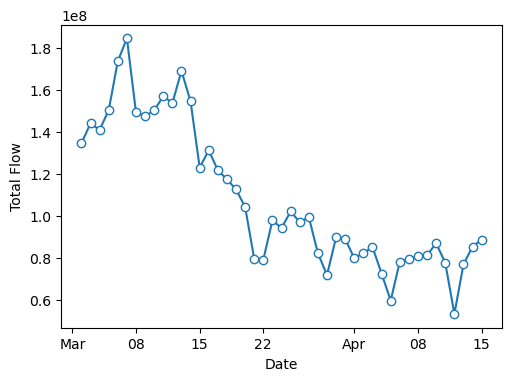

In [26]:
# ======= SOLUTION =======
# Plot the timeseries of the total population flows
# Hint: ax.plot(x, y, ...)

fig, ax = plt.subplots(figsize=(5, 3.7), layout='constrained')
ax.plot(totalFlow.index, totalFlow['pop_flows'], marker='o', markerfacecolor='white')

ax.set_ylabel("Total Flow")
ax.set_xlabel("Date")
dateFormat(ax)

&nbsp;<br><br><br><br><br><br><br><br><br>

## Deegre and Flow Distribution
Degree distribution describes the frequency of nodes by their number of connections; we expect a few highly connected hubs and many sparsely connected nodes.  

In [29]:
c2c.head(2)

,county_o,county_d,pop_flows,date
1,01001,01003,67.0,2020-04-14
2,01001,01005,11.0,2020-04-14


In [ ]:
# Select data for a specific day (use df.query)
c2cOneDay = ...

# Filter the data for flows greater than 100 (use df.query) (You can try different filtering criteria)
...

# Compute the in degree: group by destination and count the number of incoming connections
inDegree = ...

# Rename the column name for clarity
inDegree.columns = ['inDegree']

# Get the degree count using np.unique with return_counts=True (https://numpy.org/doc/stable/reference/generated/numpy.unique.html)
...

# EXTRA: do it for the outdegree, counting the outcoming connections instead incoming connections
...

In [30]:
# ======= SOLUTION =======
# Select data for a specific day
c2cOneDay = c2c.query('date == "2020-03-02"')

# Filter the data for population flows greater than or equal to 100 (You can try different filtering criteria)
c2cOneDay = c2cOneDay.query('pop_flows >= 100')

# Compute the in degree: group by destination and count the number of incoming connections
inDegree = c2cOneDay.groupby('county_d')['county_o'].count()


# Rename the column name for clarity
inDegree.columns = ['inDegree']

# Get the degree count using np.unique with return_counts=True (https://numpy.org/doc/stable/reference/generated/numpy.unique.html)
unique, counts = np.unique(inDegree, return_counts=True)

# EXTRA: do it for the outdegree, counting the outcoming connections instead incoming connections
outDegree = c2cOneDay.groupby('county_o')['county_d'].count()
outDegree.columns = ['outDegree']
uniqueOut, countsOut = np.unique(outDegree, return_counts=True)

In [ ]:
# Plot the degree distribution
fig, ax = plt.subplots(figsize=(5, 3.7), layout='constrained')
...

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("p(k)")
ax.set_xlabel("Degree")
ax.legend()

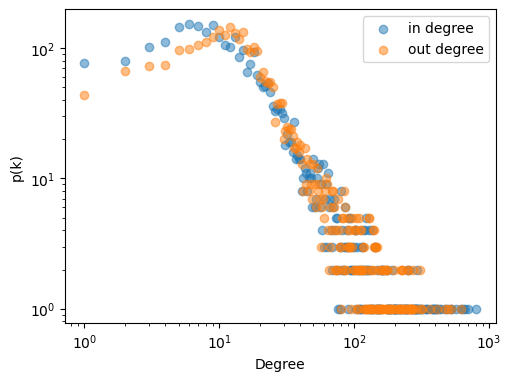

In [31]:
# ======= SOLUTION =======
# Plot the degree distribution
fig, ax = plt.subplots(figsize=(5, 3.7), layout='constrained')
ax.scatter(unique, counts, alpha=0.5, label='in degree')
ax.scatter(uniqueOut, countsOut, alpha=0.5, label='out degree')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("p(k)")
ax.set_xlabel("Degree")
ax.legend()

## EXTRA: Flow Distribution
The flow distribution describes how movement volumes are distributed across edges.

In [ ]:
# Filter data for a specified date interval like between 2020-03-01 and 2020-03-08
c2cFiltered = ...

# Take the mean daily flow for each pair of origin destination 
...

# Compute the in/out flow by summing over all connections grouped by origin or destination
inFlow = ...
outFlow = ...

# Rename the resulting series for clarity
inFlow.name = 'inFlow'
outFlow.name = 'outFlow'

# Create an histogram that count the node with certain inFlow or outFlow
# 1. what about using a using a logarithmic scale. Sse `np.linspace(start, end, num_points)
# 1.1 alternative use a logarithmic scale (use `np.logspace(start_exponent, end_exponent, num_points)`)?
# 2. create the counting using `np.histogram` (see doc at https://numpy.org/doc/2.2/reference/generated/numpy.histogram.html)
bins = ...
inFlowCounts, binEdges = ...
outFlowCounts, binEdges = ...


# Plot the distribution of inFlow and outFlow
fig, ax = plt.subplots(figsize=(5, 3.5), layout='constrained')
ax.scatter(bins[1:], inFlowCounts, alpha=0.5, label='in flow')
ax.scatter(bins[1:], outFlowCounts, alpha=0.5, label='out flow')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("p")
ax.set_xlabel("Travel Flow")
ax.legend()

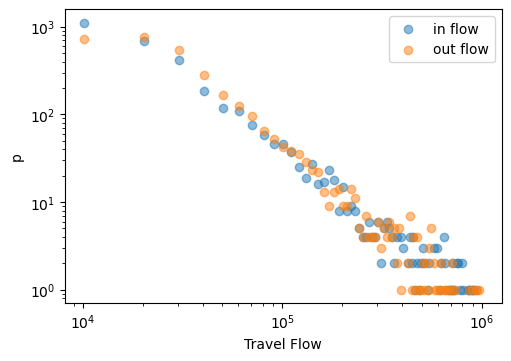

In [54]:
# ======= SOLUTION =======
# Filter data for a specified date interval like between 2020-03-01 and 2020-03-08
c2cFiltered = c2c.query('"2020-03-01" <= date <= "2020-03-08"')

# Take the mean flow for each pair of origin destination
c2cFiltered = c2cFiltered.groupby(['county_o', 'county_d'])['pop_flows'].mean().reset_index()

# Compute the in/out flow by summing over all connections grouped by origin or destination
inFlow = c2cFiltered.groupby('county_d')['pop_flows'].sum()
outFlow = c2cFiltered.groupby('county_o')['pop_flows'].sum()

# Rename the resulting series for clarity
inFlow.name = 'inFlow'
outFlow.name = 'outFlow'

# Create an histogram that count the node with certain inFlow or outFlow
# Try both logaritmic and linear binning
#bins = np.logspace(2, 7, 50)
bins = np.linspace(100, 1e6, 100)
inFlowCounts, binEdges = np.histogram(inFlow, bins=bins)
outFlowCounts, binEdges = np.histogram(outFlow, bins=bins)

# Plot the distribution of inFlow and outFlow
fig, ax = plt.subplots(figsize=(5, 3.5), layout='constrained')

ax.scatter(bins[1:], inFlowCounts, alpha=0.5, label='in flow')
ax.scatter(bins[1:], outFlowCounts, alpha=0.5, label='out flow')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("p")
ax.set_xlabel("Travel Flow")
ax.legend()

&nbsp;<br><br><br><br><br><br><br><br><br>

# Plot maps

In [36]:
# Load the shapefile at the county level
# If executing on Google Colab, change the path to:
# https://github.com/EPIcx-lab/ESPIDAM-2025---Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/otherData/US-counties.geojson

geoData = gpd.read_file('./otherData/US-counties.geojson')

# Convert the coordinate reference system to ESRI:102003
geoData = geoData.to_crs("ESRI:102003")

# Set the index to 'id' for easy access
geoData = geoData.set_index('id')

# For visualization purposes, remove Alaska, Hawaii, and Puerto Rico
geoData = geoData.query('STATE not in ["02", "15", "72"]')

geoData.head(2)

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
id,,,,,,,
01001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((888385.589 -532160.711, 867146.329 -..."
01009,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((865138.928 -375110.799, 847724.195 -..."


## Inspect the map dataset

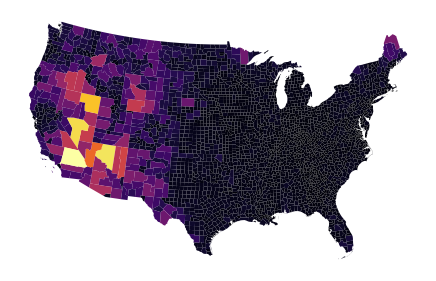

In [37]:
# Plot the county boundaries, and color each county accordingly to a certain column values (EX: CENSUSAREA)
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
geoData.plot(column='CENSUSAREA', linewidth=0.5, cmap='inferno', ax=ax)

# Remove the axis
ax.axis('off');

## Plot flows

In [38]:
# Compute the county in and out flow
inFlow = c2c.query('date == "2020-03-02"').groupby('county_d')[['pop_flows']].sum()
outFlow = c2c.query('date == "2020-03-02"').groupby('county_o')[['pop_flows']].sum()
inFlow.columns = ['inFlow']
outFlow.columns = ['outFlow']

In [39]:
geoData.sort_index().head(2)

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
id,,,,,,,
01001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((888385.589 -532160.711, 867146.329 -..."
01003,0500000US01003,01,003,Baldwin,County,1589.784,"POLYGON ((798881.510 -691268.806, 799545.744 -..."


In [40]:
inFlow.sort_index().head(2)

,inFlow
county_d,
01001,27715.0
01003,91856.0


In [ ]:
# 1) Add the 'inFlow' and 'outFlow' columns to geoData.  
#    Since the indexes match, we can assign directly (with non-matching indexes will get NaN) like geoData['new_column'] = other_df
...


# 2) Plot the map coloring bases on inFlow and outFlow
fig, axs = plt.subplots(figsize=(10, 3), ncols=2, layout='constrained')

# Define a logarithmic normalization for color scaling. Use it in plot function as norm=colorNorm
colorNorm = mpl.colors.LogNorm(vmin=geoData[['inFlow', 'outFlow']].min().min(), vmax=geoData[['inFlow', 'outFlow']].max().max())

# Plot 'inFlow' data
ax = axs[0]
...

# Plot 'outFlow' data
ax = axs[1]
...

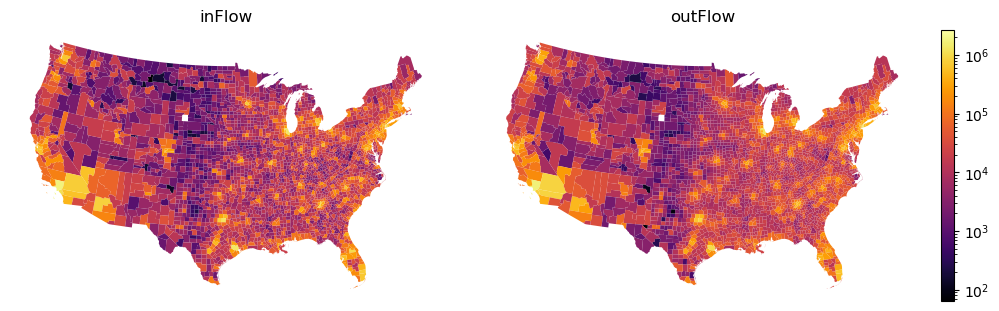

In [41]:
# ======= SOLUTION =======
# 1) Add the 'inFlow' and 'outFlow' columns to geoData. 
geoData['inFlow'] = inFlow
geoData['outFlow'] = outFlow

# 2) Plot the map coloring bases on inFlow and outFlow
fig, axs = plt.subplots(figsize=(10, 3), ncols=2, layout='constrained')

# Define a logarithmic normalization for color scaling. Use it in plot function as norm=colorNorm
colorNorm = mpl.colors.LogNorm(vmin=geoData[['inFlow', 'outFlow']].min().min(), vmax=geoData[['inFlow', 'outFlow']].max().max())

# Plot 'inFlow' data
ax = axs[0]
ax.axis('off') 
ax.set_title('inFlow')
geoData.plot(column='inFlow', cmap='inferno', norm=colorNorm, ax=ax)

# Plot 'outFlow' data
ax = axs[1]
ax.axis('off')
ax.set_title('outFlow')
geoData.plot(column='outFlow', cmap='inferno', norm=colorNorm, ax=ax, legend=True);

## Plot the % change in mobility between 2 dates

In [ ]:
# Get the node outflows for two dates (dataset span from 2020-03-02 to 2020-04-15)
outFlowPre = ...
outFlowPost = ...

# Compute the percentage variation
# Hint: you can perform mathematical operations directly between DataFrame columns
diff = ...
diff.columns = ['diffFlow']

# Merge the variation into geoData
...

# Plot
colorNorm = mpl.colors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100)
...

<Axes: title={'center': 'Mobility variations'}>

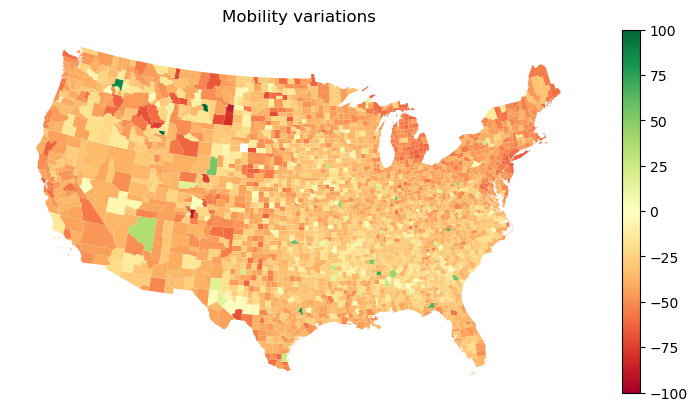

In [26]:
# ======= SOLUTION =======
# Get the node outflows for two dates
outFlowPre = c2c.query('date == "2020-03-03"').groupby('county_o')[['pop_flows']].sum()
outFlowPost = c2c.query('date == "2020-04-10"').groupby('county_o')[['pop_flows']].sum()

# Compute the percentage variation
diff = ((outFlowPost - outFlowPre) / outFlowPre) * 100
diff.columns = ['diffFlow']

# Merge the variation into geoData
geoData['diffFlow'] = diff

# Plot
fig, ax = plt.subplots(figsize=(8, 4), ncols=1, layout='constrained')

# Set color normalization with center at 0
colorNorm = mpl.colors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100)

ax.axis('off')
ax.set_title('Mobility variations')
geoData.plot(column='diffFlow', cmap='RdYlGn', norm=colorNorm, ax=ax, legend=True)

In [138]:
# Pre vs post-lockdown  
# Early lockdown period vs later lockdown period  
# Weekends vs weekdays  
# Inflow vs outflow

&nbsp;<br><br><br><br><br><br><br><br><br>

# Covid Lockdown
Inspect mobility changes during first COVID lockdown in specific locations

In [44]:
# FIPS codes related to NYC  and  San Francisco
FIPS_NYC = {'36005', '36047', '36061', '36081', '36085', '35620'}
FIPS_SanFrancisco = {'06075', '06081', '06013', '06001', '06041'}

In [ ]:
# Filter the data to obtain the VISITORS flow to NYC not originating from NYC
# Alternative: Filter the data to obtain the VISITORS flow to NYC not originating from NYC
# Hint: in df.query you can use syntax like (column in @variable) to check if values are in a list and `not` to negate

visitorNYC = ...

# Use groupby to obtain the total visitors per day
...

# Repeat for San Francisco
...

In [45]:
# ======= SOLUTION =======
# Filter the data to obtain the VISITORS flow to NYC not originating from NYC
# Alternative: Filter the data to obtain the VISITORS flow to NYC not originating from NYC
# Hint: in df.query you can use syntax like (column in @variable) to check if values are in a list and `not` to negate

visitorNYC = c2c.query("(county_d in @FIPS_NYC) and not (county_o in @FIPS_NYC)")
#visitorNYC = c2c.query("county_d in @FIPS_NYC")

# Use groupby to obtain the total visitors per day
visitorNYC = visitorNYC.groupby('date')['pop_flows'].sum()

# Repeat for San Francisco
visitorSF = c2c.query("(county_d in @FIPS_SanFrancisco) and not (county_o in @FIPS_SanFrancisco)")
#visitorSF = c2c.query("county_d in @FIPS_SanFrancisco")
visitorSF = visitorSF.groupby('date')['pop_flows'].sum()

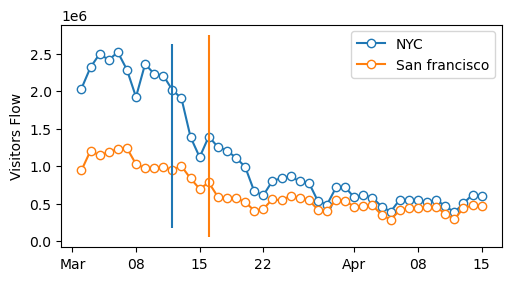

In [46]:
# Plot timeseries of visitors
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

ax.plot(visitorNYC.index, visitorNYC.values, marker='o', markerfacecolor='white', label='NYC')
ax.plot(visitorSF.index,  visitorSF.values,  marker='o', markerfacecolor='white', label='San francisco')

dateFormat(ax)
ax.legend()
ax.set_ylabel('Visitors Flow');

ax.vlines(pd.Timestamp('2020-03-12'), *ax.get_ylim(), color='C0')
ax.vlines(pd.Timestamp('2020-03-16'), *ax.get_ylim(), color='C1')

In [ ]:
# What about rural areas?

# EXTRA: Add trip distances

In [47]:
# Load the JSON file with county coordinates
# If executing on Google Colab, change the path to:
# https://github.com/EPIcx-lab/ESPIDAM-2025---Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/otherData/US-counties.geojson
geoData = gpd.read_file('./otherData/US-counties.geojson')
geoData = geoData.to_crs("ESRI:102003")
geoData = geoData.set_index('id')

# Compute the centroid for each county
geoData["centroid"] = geoData.centroid

# Filter the data to obtain the VISITORS flow to NYC 
FIPS_NYC = {'36005', '36047', '36061', '36081', '36085', '35620'}
visitorNYC = c2c.query("(county_d in @FIPS_NYC) and not (county_o in @FIPS_NYC)").copy()

# Map centroids to origin and destination counties in visitorNYC
# Hint: Use the function map on column county_o and county_d
visitorNYC['centroid_o'] = visitorNYC['county_o'].map(geoData['centroid'])
visitorNYC['centroid_d'] = visitorNYC['county_d'].map(geoData['centroid'])

In [48]:
visitorNYC.head(2)

,county_o,county_d,pop_flows,date,centroid_o,centroid_d
141,01001,36081,22.0,2020-04-14,POINT (872827.105 -512222.804),POINT (1841926.831 574485.540)
666,01003,36047,10.0,2020-04-14,POINT (789680.937 -722454.792),POINT (1833288.331 565648.684)


In [49]:
# Compute the distances
visitorNYC['distance'] = gpd.GeoSeries(visitorNYC['centroid_o'], crs="ESRI:102003").distance(gpd.GeoSeries(visitorNYC['centroid_d'], crs="ESRI:102003"))

# Convert distance from meters to kilometers
visitorNYC['distance'] /= 1000

# Display the first 2 rows of the resulting DataFrame
visitorNYC.head(2)

,county_o,county_d,pop_flows,date,centroid_o,centroid_d,distance
141,01001,36081,22.0,2020-04-14,POINT (872827.105 -512222.804),POINT (1841926.831 574485.540),1456.052645
666,01003,36047,10.0,2020-04-14,POINT (789680.937 -722454.792),POINT (1833288.331 565648.684),1657.807878


## Long vs Short mobility

In [ ]:
# Create two dataset containing long and short mobility
...


# Use groupby to obtain the total visitor per day
...

# Normalize the timeseries
# Take the period before the restrictions (ex '2020-03-18') and compute the average number of visitor
# Divide the whole timeseies by the average pre-intervention number of visitors 
...

# Plot the timeseries
... 
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

...

dateFormat(ax)
ax.legend()
ax.set_ylabel('Reduction of\nvisitors Flow');

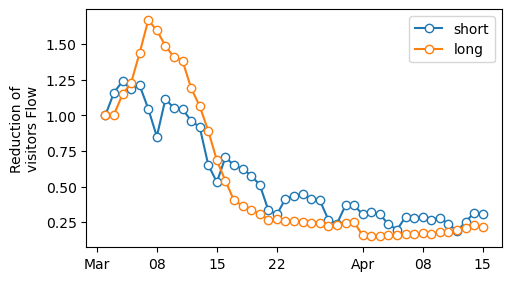

In [50]:
# ======= SOLUTION =======
# Create two dataset containing long and short mobility
short = visitorNYC.query('distance < 700')
long = visitorNYC.query('distance >= 700')

# Use groupby to obtain the total visitor per day
long = long.groupby('date')['pop_flows'].sum()
short = short.groupby('date')['pop_flows'].sum()

# Normalize the timeseries
# Take the period before the restrictions (ex '2020-03-18') and compute the average number of visitor
# Divide the whole timeseies by the average pre-intervention number of visitors 
long /= long.loc['2020-03-02']
short /= short.loc['2020-03-02']

# Plot the timeseries
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

ax.plot(short.index, short.values, marker='o', markerfacecolor='white', label='short')
ax.plot(long.index, long.values, marker='o', markerfacecolor='white', label='long', c='C1')

dateFormat(ax)
ax.legend()
ax.set_ylabel('Reduction of\nvisitors Flow');

&nbsp;<br><br><br><br><br><br><br><br><br>

# Gravity Model for Mobility

The gravity model for mobility is a mathematical model used to predict and describe the movement of individuals between different locations. 
It is analogous to Newton's law of gravitation, where the interaction between two locations is proportional to their "masses" (e.g., population sizes) and inversely proportional to the distance between them. 
The generalized gravity model introduces exponents to all the coefficients, allowing for more flexibility and accuracy in capturing the complexities of human mobility.


The formula for the generalized gravity model is given by:
$$T_{ij} = k \frac{P_i^{\alpha} P_j^{\beta}}{D_{ij}^{\gamma}}$$

where:
- $ T_{ij} $ is the predicted flow from location $ i $ to location $ j $
- $P_i $ and $ P_j $ are the populations of locations $ i $ and $ j $, respectively
- $D_{ij} $ is the distance between locations $ i $ and $ j $
- $k $ is a constant
- $\alpha $, $ \beta $, and $ \gamma $ are the exponents that adjust the influence of the populations and distance on the flow  


Here we fit a gravity model to describe the flow **between states**  
We are going to fit the model by applying the log of both side so that we obtain a linear model
$$\log(T_{ij}) = \log(k) + \alpha \log(P_i) + \beta \log({P_j}) - \gamma \log({D_{ij})}$$


In [34]:
# 1) Population 
# https://github.com/EPIcx-lab/ESPIDAM-2025---Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/otherData/USPopStates.csv
popState = pd.read_csv("./otherData/USPopStates.csv", dtype={"state": str}, index_col=0)
popState.head(2)

,pop
state,
01,4830620
02,733375


In [35]:
# 2) Mobility Flow 
# https://github.com/EPIcx-lab/ESPIDAM-2025---Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/mobilityflows/mobilityFlowsState.csv.xz
s2s = pd.read_csv('./mobilityflows/mobilityFlowsState.csv.xz', dtype={"state_o": str, "state_d": str})
s2s.head(2)

,state_o,state_d,pop_flows
0,01,02,263.4
1,01,04,3304.4


In [36]:
# 3) Distances
# https://github.com/EPIcx-lab/ESPIDAM-2025---Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/otherData/US-states.geojson
geoState = gpd.read_file('./otherData/US-states.geojson')
geoState = geoState.to_crs("ESRI:102003")
geoState = geoState.set_index('GEOID')

# Compute the controid for each county
geoState["centroid"] = geoState.centroid
geoState.head(2)

,STATEFP,STATENS,AFFGEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,centroid
GEOID,,,,,,,,,,
28,28,01779790,0400000US28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((719952.837 -785108.098, 721081...",POINT (589578.824 -513115.148)
37,37,01027616,0400000US37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((1799007.580 17387.012, 1799662...",POINT (1486706.652 -87524.808)


In [37]:
# 4) Merge the three dataset

# add population to the travel dataset
s2s['pop_o'] = popState.loc[s2s['state_o']].values
s2s['pop_d'] = popState.loc[s2s['state_d']].values

# add centroid to the travel dataset
s2s['centroid_o'] = s2s['state_o'].map(geoState['centroid'])
s2s['centroid_d'] = s2s['state_d'].map(geoState['centroid'])
s2s = s2s.dropna()

# compute distance between centroid
s2s['distance'] = gpd.GeoSeries(s2s['centroid_o'], crs="ESRI:102003").distance(gpd.GeoSeries(s2s['centroid_d'], crs="ESRI:102003"))

# distance from m to km
s2s['distance'] /= 1000

s2s = s2s[['state_o','state_d','pop_flows','pop_o','pop_d','distance']]

In [38]:
s2s.head()

,state_o,state_d,pop_flows,pop_o,pop_d,distance
0,01,02,263.4,4830620,733375,5788.619571
1,01,04,3304.4,4830620,6641928,2290.037358
2,01,05,5505.6,4830620,2958208,567.241415
3,01,06,7562.8,4830620,38421464,2980.629030
4,01,08,3769.6,4830620,5278906,1809.669167


In [ ]:
# Prepare transformed variables for the regression (the log values and a constant)
s2s['log_pop_o'] = ...        
...                               

# Define independent variables (X) and dependent variable (y)
X = ...
y = ...

# Fit an ordinary least squares (OLS) linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Display estimated model coefficients
results.params

In [ ]:
K_fitted = ...
a_fitted = ... 
...

# Predict travel flows using the fitted gravity model parameters
T_ij_predicted = ...

# Create a scatter plot: true flows vs. predicted flows
fig, ax = plt.subplots(figsize=(3,3), layout='constrained')
...

Text(0, 0.5, 'predicted flow')

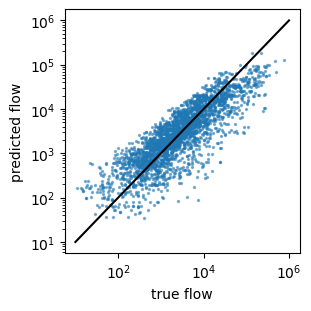

In [51]:
# ===== SOLUTION =====
# Prepare transformed variables for the regression (ex Log of origin population)
s2s['log_pop_o'] = np.log10(s2s['pop_o'])          
s2s['log_pop_d'] = np.log10(s2s['pop_d'])          
s2s['log_distance'] = np.log10(s2s['distance'])    
s2s['log_pop_flows'] = np.log10(s2s['pop_flows'])  
s2s['const'] = 1                                   

# Define independent variables (X) and dependent variable (y)
X = s2s[['log_pop_o', 'log_pop_d', 'log_distance', 'const']]
y = s2s['log_pop_flows']

# Fit an ordinary least squares (OLS) linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Display estimated model coefficients
results.params

K_fitted = results.params.loc['const']
a_fitted = results.params.loc['log_pop_o']
c_fitted = results.params.loc['log_pop_d']
b_fitted = results.params.loc['log_distance']

# Predict travel flows using the fitted gravity model parameters
# T_ij_predicted = K_fitted * (P_i ** a_fitted) * (P_j ** c_fitted) * (D_ij ** b_fitted)
T_ij_predicted = 10**K_fitted * (s2s['pop_o'] ** a_fitted) * (s2s['pop_d'] ** c_fitted) * (s2s['distance'] ** b_fitted)

# Create a scatter plot: true flows vs. predicted flows
fig, ax = plt.subplots(figsize=(3,3), layout='constrained')
ax.scatter(s2s['pop_flows'], T_ij_predicted, s=2, alpha=0.5)
ax.plot([1e1,1e6], [1e1,1e6], color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('true flow')
ax.set_ylabel('predicted flow')

&nbsp;<br><br><br><br><br><br><br><br><br>

# EXTRA: Visualize the travel network

In [52]:
# Install networkx if needed
#!pip install networkx

In [4]:
import networkx as nx
hideStates = ['02', '69','44' ,'66' ,'15' ,'60' ,'78' ,'72']

#### 1) Load the dataset

In [5]:
# 1) NODE dataset
# # https://github.com/EPIcx-lab/ESPIDAM-2025---Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/otherData/US-states.geojson
geoState = gpd.read_file('./otherData/US-states.geojson')
geoState = geoState.to_crs("ESRI:102003")
geoState = geoState.set_index('GEOID')
geoState = geoState.query("STATEFP not in @hideStates")
geoState["centroid"] = geoState.centroid
nodes = geoState.copy()

In [6]:
# 2) LINK dataset: the mobility Flow 
# # https://github.com/EPIcx-lab/ESPIDAM-2025---Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/mobilityflows/mobilityFlowsState.csv.xz
s2s = pd.read_csv('./mobilityflows/mobilityFlowsState.csv.xz', dtype={"state_o": str, "state_d": str})
s2s = s2s.query("(state_o not in @hideStates) and (state_d not in @hideStates)")
links = s2s.copy()

In [8]:
links.head(2)

,state_o,state_d,pop_flows
1,01,04,3304.4
2,01,05,5505.6


In [9]:
nodes.head(1)

,STATEFP,STATENS,AFFGEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,centroid
GEOID,,,,,,,,,,
28,28,01779790,0400000US28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((719952.837 -785108.098, 721081...",POINT (589578.824 -513115.148)


#### 2) Prepare the node and link dataset

In [ ]:
# Keep only rows where pop_flows is greater than 1000
...

# Remove flows within the same state.
...

# Remove flows that include the hidden states.
# Hint: Use the query method and access the local variable hideStates with @hideStates in the query string.
...

# The flow of passengers will represent the links' weight in the network.
# Hint: Transform the flow into values between 0 and 10, creating a new column 'w'.
...

# Compute total outflow per state and add it as a new column in the node dataset.
# Hint: Normalize the values between 0 and 300, creating a new column 'w'.
...

In [43]:
# ===== SOLUTION =====
# Keep only rows where pop_flows is greater than 1000
links = links.query('pop_flows > 1000')

# Remove flows within the same state.
links = links.query('state_o != state_d')

# Remove flows that include the hidden states.
# Hint: Use the query method and access the local variable hideStates with @hideStates in the query string.
links = links.query("(state_o not in @hideStates) and (state_d not in @hideStates)")

# The flow of passengers will represent the links' weight in the network.
# Hint: Transform the flow into values between 0 and 10, creating a new column 'w'.
minVal, maxVal = links['pop_flows'].min(), links['pop_flows'].max()
links['w'] = (links['pop_flows'] - minVal) * (10 / (maxVal - minVal))

# Compute total outflow per state and add it as a new column in the node dataset.
# Hint: Normalize the values between 0 and 300, creating a new column 'w'.
stateOutflow = links.groupby('state_o')['pop_flows'].sum()
minVal, maxVal = stateOutflow.min(), stateOutflow.max()
stateOutflow = (stateOutflow - minVal) * (300 / (maxVal - minVal))
nodes['w'] = stateOutflow

#### 3) Crete the network

In [ ]:
# ===== SOLUTION =====
# Create the network with NetworkX
G = nx.Graph()

# Add nodes to the graph named with the state code.
# Hint: Iterate over the rows of nodes dataframe using `for index, val in df.iterrows()`
# Hint: Iterate over the geoState dataframe and use G.add_node() to add each state.
for index, val in nodes.iterrows():
    ...

# Add links to the graph
# Hint: Use G.add_edge(nodeFrom, nodeTo, weight=) to add each link.
...

# Create a dictionary for each state code with two values (x, y) equal to the centroid.
pos = {}
for _, row in geoState.iterrows():
    pos[row['STATEFP']] = (row['geometry'].centroid.x, row['geometry'].centroid.y)

In [44]:
# ===== SOLUTION =====
# Create the network with NetworkX
G = nx.Graph()

# Add nodes to the graph named with the state code.
# Hint: Iterate over the rows of nodes dataframe using `for index, val in df.iterrows()`
# Hint: Iterate over the geoState dataframe and use G.add_node() to add each state.
for index, val in nodes.iterrows():
    G.add_node(index, weight=val['w'])

# Add links to the graph
# Hint: Use G.add_edge(nodeFrom, nodeTo, weight=) to add each link.
for index, val in links.iterrows():
    G.add_edge(val['state_o'], val['state_d'], weight=val['w'])

# Create a dictionary for each state code with two values (x, y) equal to the centroid.
# Hint: Iterate over geoState, calculate the centroid, and access the properties x and y.
pos = {}
for _, row in geoState.iterrows():
    pos[row['STATEFP']] = (row['geometry'].centroid.x, row['geometry'].centroid.y)

#### 4) Plot

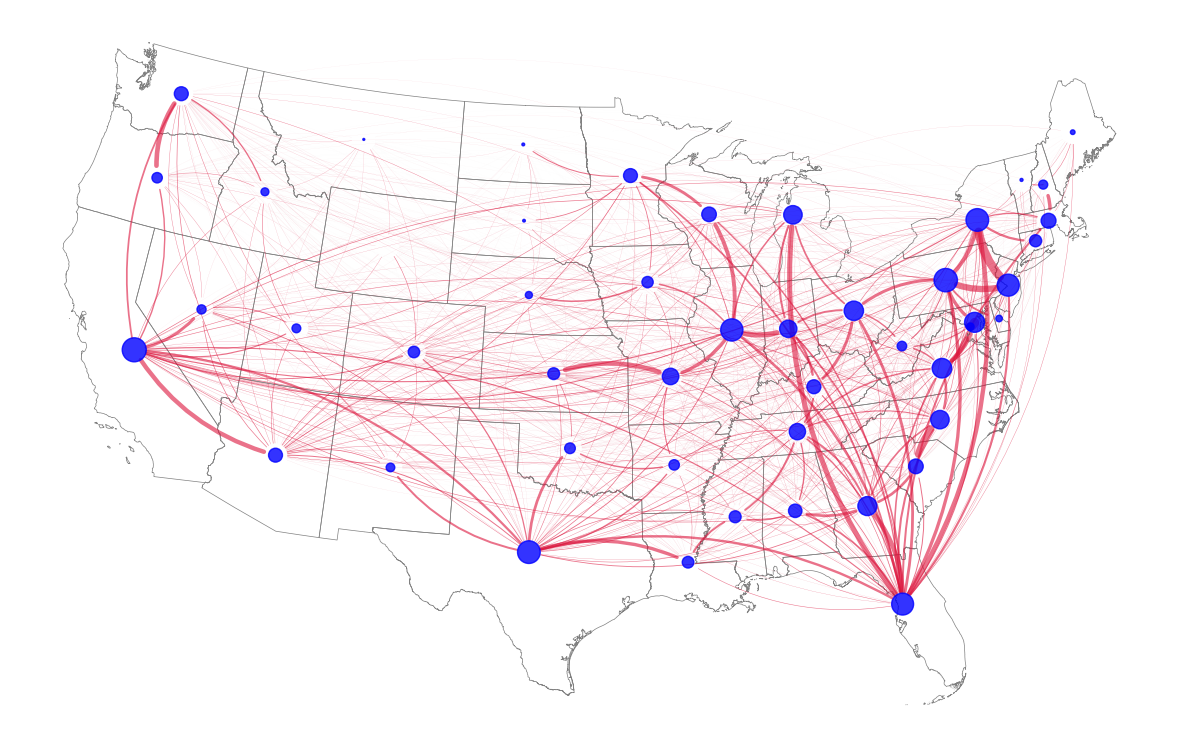

In [42]:
fig, ax = plt.subplots(figsize=(15, 10))
geoState.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5)

# Edge weights
widths = nx.get_edge_attributes(G, 'weight')
nodeDimension = nx.get_node_attributes(G, 'weight')

# Draw nodes
nx.draw_networkx_nodes(G, pos, ax=ax,
                       node_size=[nodeDimension[n] for n in G.nodes()],
                       node_color='blue',
                       alpha=0.8)

# Draw curved edges with FancyArrowPatch
nx.draw_networkx_edges(G, pos, ax=ax,
                       edgelist=widths.keys(),
                       width=list(widths.values()),
                       edge_color='crimson',
                       alpha=0.6,
                       connectionstyle='arc3,rad=0.2',
                       arrows=True)

ax.axis('off');